#DDQN Vanilla Cart Pole Environment

In [ ]:
# !pip install gymnasium
!pip3 install gymnasium[classic_control]

import gymnasium as gym
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [ ]:
env = gym.make('CartPole-v1')

obs, info = env.reset()

obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

obs, info, obs_space, action_space

(array([ 0.03794919,  0.01555944, -0.02875545,  0.03454918], dtype=float32),
 {},
 4,
 2)

In [ ]:
class DDQNnn(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(obs_space, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, action_space)
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

nn_first = DDQNnn()
nn_second = DDQNnn()
dict_load = nn_first.state_dict()
nn_second.load_state_dict(dict_load)

nn_first, nn_second

(DDQNnn(
   (linear_relu_stack): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=2, bias=True)
   )
 ),
 DDQNnn(
   (linear_relu_stack): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=2, bias=True)
   )
 ))

In [ ]:
import random
import numpy as np

from collections import deque
buffer_memory = deque(maxlen = 10000)

def policy_cal(obs):
  random_val = random.random()
  epsilon_val = epsilon_cal()
  if random_val > epsilon_val:
    action_type = 'greedy'
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    action_val = nn_first(obs_tensor).detach().numpy()
    action_val = np.argmax(action_val)
    return action_val, action_type
  else:
    action_type = 'random'
    action_val = env.action_space.sample()
    return action_val, action_type

def policy_learnt(obs):
  action_type = 'greedy'
  obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
  action_val = nn_first(obs_tensor).detach().numpy()
  action_val = np.argmax(action_val)
  return action_val, action_type

import math
epsilon_steps = 0
def epsilon_cal():
  diff_val = 1.0 - 0.05
  global epsilon_steps
  exp_val = math.exp(-1.0 * epsilon_steps / 1000)
  epsilon_steps += 1
  epsilon_val = 0.05 + diff_val * exp_val
  return epsilon_val

optimizer_param = nn_first.parameters()
optimizer = torch.optim.AdamW(optimizer_param, lr=1e-4, amsgrad=True)

In [ ]:
def experience_cal():
  if len(buffer_memory) < 128:
    return
  
  buffer_batch = random.sample(buffer_memory, 128)
  batch_obs1, batch_obs2 = [], []
  batch_reward, batch_action = [], []
  batch_completed = []

  for val in buffer_batch:
    obs1_val, obs2_val, reward_val, action_val, completed_val = val
    batch_completed.append(completed_val)
    batch_obs1.append(obs1_val)
    batch_obs2.append(obs2_val)
    batch_action.append([action_val])
    batch_reward.append(reward_val)    
  
  batch_obs2_nf = []
  for i in range(len(batch_completed)):
    if batch_completed[i]:
      batch_obs2_nf.append(batch_obs2[i])
  
  batch_completed = torch.tensor(batch_completed, dtype=torch.bool) # 128
  batch_obs1 = torch.tensor(batch_obs1) # 128
  batch_obs2 = torch.tensor(batch_obs2) # 128
  batch_obs2_nf = torch.tensor(batch_obs2_nf) # < 128
  batch_action = torch.tensor(batch_action, dtype=torch.int64) # 128
  batch_reward = torch.tensor(batch_reward) # 128
  
  obs1_qval = nn_first(batch_obs1).gather(1, batch_action)
  obs2_qval = nn_second(batch_obs1).gather(1, batch_action)

  batch_obs2_val = torch.zeros(128)
  with torch.set_grad_enabled(False):
    max_val_list = nn_second(batch_obs2_nf).detach()
    max_val = max_val_list.max(1)[0]
    batch_obs2_val[batch_completed] = max_val

  discounted_reward = 0.99 * batch_obs2_val
  obs2_qval = batch_reward + discounted_reward
  
  loss_function = torch.nn.MSELoss()
  criterion = loss_function
  loss_param1 = obs1_qval
  loss_param2 = obs2_qval[:, None]
  loss = criterion(loss_param1, loss_param2)

  optimizer.zero_grad()
  loss.backward()
  
  grad_max_val = 100
  grad_model_param = nn_first.parameters()
  torch.nn.utils.clip_grad_value_(grad_model_param, grad_max_val)
  
  optimizer.step()

  update_cf1 = 0.005
  update_cf2 = 1 - 0.005
  nn_first_dict = nn_first.state_dict()
  nn_second_dict = nn_second.state_dict()
  for dict_key in nn_first.state_dict():
    nn_first_update = update_cf1 * nn_first_dict[dict_key]
    nn_second_update = update_cf2 * nn_second_dict[dict_key]
    update_val = nn_first_update + nn_second_update
    nn_second_dict[dict_key] = update_val
  nn_second.load_state_dict(nn_second_dict)

In [ ]:
rewards = []
for episode in range(500):
  obs1_val, info_val = env.reset()
  completed, term_val, trunc_val = False, False, False
  score, greedy_count, random_count = 0, 0, 0

  while not completed:
    action_val, action_type = policy_cal(obs1_val)
    if action_type == 'greedy':
      greedy_count += 1
    else:
      random_count += 1
  
    obs2_val, reward_val, term_val, trunc_val, info_val = env.step(action_val)
    score += reward_val

    completed = term_val or trunc_val
    completed_val = not completed

    experience = (obs1_val, obs2_val, reward_val, action_val, completed_val)
    buffer_memory.append(experience)
    obs1_val = obs2_val

    experience_cal()

    if completed:
      print(f'Episode: {episode}, Score: {score}, Random: {random_count}, Greedy: {greedy_count}')
      rewards.append(score)
      break

Episode: 0, Score: 40.0, Random: 33, Greedy: 7
Episode: 1, Score: 12.0, Random: 10, Greedy: 2
Episode: 2, Score: 30.0, Random: 24, Greedy: 6
Episode: 3, Score: 13.0, Random: 8, Greedy: 5
Episode: 4, Score: 10.0, Random: 5, Greedy: 5
Episode: 5, Score: 16.0, Random: 15, Greedy: 1
Episode: 6, Score: 21.0, Random: 17, Greedy: 4
Episode: 7, Score: 17.0, Random: 10, Greedy: 7
Episode: 8, Score: 12.0, Random: 7, Greedy: 5
Episode: 9, Score: 11.0, Random: 7, Greedy: 4
Episode: 10, Score: 13.0, Random: 9, Greedy: 4
Episode: 11, Score: 13.0, Random: 8, Greedy: 5
Episode: 12, Score: 25.0, Random: 20, Greedy: 5
Episode: 13, Score: 14.0, Random: 11, Greedy: 3
Episode: 14, Score: 14.0, Random: 9, Greedy: 5
Episode: 15, Score: 12.0, Random: 9, Greedy: 3
Episode: 16, Score: 10.0, Random: 4, Greedy: 6
Episode: 17, Score: 9.0, Random: 8, Greedy: 1
Episode: 18, Score: 19.0, Random: 14, Greedy: 5
Episode: 19, Score: 16.0, Random: 9, Greedy: 7
Episode: 20, Score: 16.0, Random: 11, Greedy: 5
Episode: 21, S

In [ ]:
rewards_test = []
for episode in range(10):
  obs1_val, info_val = env.reset()
  completed, term_val, trunc_val = False, False, False
  score, greedy_count, random_count = 0, 0, 0

  while not completed:
    action_val, action_type = policy_learnt(obs1_val)
    if action_type == 'greedy':
      greedy_count += 1
    else:
      random_count += 1
  
    obs2_val, reward_val, term_val, trunc_val, info_val = env.step(action_val)
    score += reward_val

    completed = term_val or trunc_val

    obs1_val = obs2_val

    if completed:
      print(f'Episode: {episode}, Score: {score}, Random: {random_count}, Greedy: {greedy_count}')
      rewards_test.append(score)
      break

Episode: 0, Score: 500.0, Random: 0, Greedy: 500
Episode: 1, Score: 500.0, Random: 0, Greedy: 500
Episode: 2, Score: 500.0, Random: 0, Greedy: 500
Episode: 3, Score: 500.0, Random: 0, Greedy: 500
Episode: 4, Score: 500.0, Random: 0, Greedy: 500
Episode: 5, Score: 500.0, Random: 0, Greedy: 500
Episode: 6, Score: 500.0, Random: 0, Greedy: 500
Episode: 7, Score: 500.0, Random: 0, Greedy: 500
Episode: 8, Score: 500.0, Random: 0, Greedy: 500
Episode: 9, Score: 500.0, Random: 0, Greedy: 500


In [ ]:
torch.save(nn_first.state_dict(), 'ddqn_vanilla_cartpole_weights.pth')

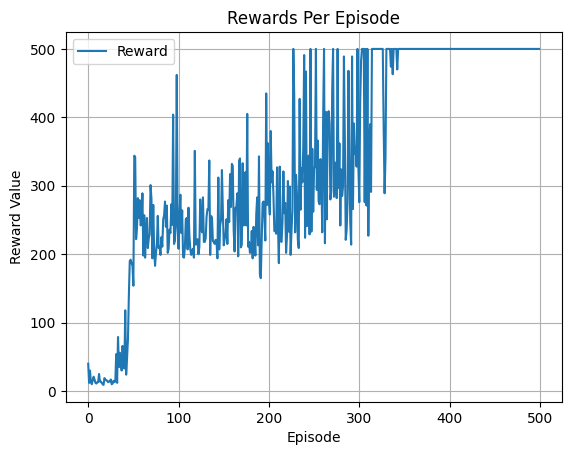

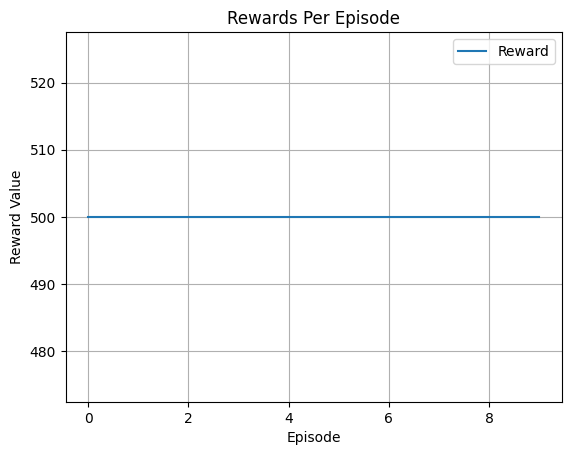

In [ ]:
import matplotlib.pyplot as plt

def plot_reward(reward):
  plt.plot(reward, label='Reward')
  plt.xlabel('Episode')
  plt.ylabel('Reward Value')
  plt.title('Rewards Per Episode')
  plt.grid()
  plt.legend()
  plt.show()

plot_reward(rewards)
plot_reward(rewards_test)

In [ ]:
import pickle
with open('ddqn_vanilla_cartpole_train.pkl', 'wb') as file:
  pickle.dump(rewards, file)

with open('ddqn_vanilla_cartpole_test.pkl', 'wb') as file:
  pickle.dump(rewards_test, file)